In [32]:
%load_ext autoreload
%autoreload 2
import importlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import os

os.environ["MODEL_DIR"] = "../model"

In [34]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [35]:
import argparse
import os

import numpy as np
import pandas as pd
import matplotlib

import matplotlib.pyplot as plt

from mapie.classification import MapieClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from src.conformal_prediction.utils import chunked_mapie_predict

# For loading your trained TransformerClassifier
from src.training.model import TransformerClassifier
from src.utils import load_config, get_logger

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [36]:
# Load config
env = "prod"
model_type = "BERT"

training_config = load_config(
    file_name="training_config", env=env, folder="../../config"
)

In [37]:
input_dataset = f"../../output_data/{env}/supervised_dataset.parquet"
input_model = f"../../output_models/{env}/trained_model"
# input_model = f"../../output_models/{env}/temp_model_16-01"
input_outliers = f"../../output_data/{env}/supervised_dataset_phase2.parquet"
output_reports = f"../../output_reports/{env}/outlier_detection"
alpha = 0.2

In [38]:
df = pd.read_parquet(input_dataset)

In [39]:
# Load a pre-trained model for paraphrasing Augment Spanish by BERT
aug = naw.ContextualWordEmbsAug(model_path="bert-base-multilingual-uncased", aug_p=0.1)

In [40]:
# Select features and target
X = df[training_config.training[model_type].features]
y = df[training_config.training[model_type].target]
num_labels = y.nunique()

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=training_config.training[model_type].test_size,
    random_state=training_config.training.random_state,
    stratify=y,
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=training_config.training[model_type].val_size,
    random_state=training_config.training.random_state,
    stratify=y_train,
)
X_test, X_cp, y_test, y_cp = train_test_split(
    X_test,
    y_test,
    test_size=training_config.training[model_type].cp_size,
    random_state=training_config.training.random_state,
    stratify=y_test,
)

In [45]:
X_train_augmented = X_train.copy()
X_train_augmented = X_train_augmented.apply(lambda x: aug.augment(x)[0])

X_train_augmented = pd.concat([X_train_augmented, X_train], ignore_index=True)
y_train_augmented = pd.concat([y_train, y_train], ignore_index=True)

In [46]:
# Upsample the minority class
from sklearn.utils import resample

X_upsampled = X_train_augmented.copy().to_frame()
X_upsampled[training_config.training[model_type].target] = y_train_augmented

# Separate majority and minority classes
df_majority = X_upsampled[X_upsampled[training_config.training[model_type].target] == 0]
df_minority = X_upsampled[X_upsampled[training_config.training[model_type].target] == 1]

# Upsample minority class
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=df_majority.shape[0],
    random_state=42,
)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
X_train = df_upsampled[training_config.training[model_type].features]
y_train = df_upsampled[training_config.training[model_type].target]

In [47]:
y_train.value_counts()

label
0    996
1    996
Name: count, dtype: int64

In [48]:
y_val.value_counts()

label
0    88
1    69
Name: count, dtype: int64

In [49]:
y_test.value_counts()

label
0    97
1    77
Name: count, dtype: int64

In [50]:
y_cp.value_counts()

label
0    98
1    77
Name: count, dtype: int64

# Train the model

In [51]:
clf = TransformerClassifier(
    model_name="dtorber/bert-base-spanish-wwm-cased_K4",
    num_labels=num_labels,
)

In [52]:
clf = clf.fit(
    X=X_train,
    y=y_train,
    eval_X=X_val,
    eval_y=y_val,
    learning_rate=2e-5,
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    early_stopping_patience=2,
    # freeze_layers_prefix=["bert.embeddings", "bert.encoder"],
    # freeze_layers_prefix=["bert.embeddings"] + [f"bert.encoder.layer.{i}" for i in range(1, 9)],
)

Epoch,Training Loss,Validation Loss
1,0.240800,0.162596
2,0.320800,0.141222
3,0.094700,0.371522
4,0.093000,0.321876


In [53]:
clf.model.save_pretrained("../../output_models/prod/model_augmented_1")
clf.tokenizer.save_pretrained("../../output_models/prod/model_augmented_1")

('../../output_models/prod/model_augmented_1\\tokenizer_config.json',
 '../../output_models/prod/model_augmented_1\\special_tokens_map.json',
 '../../output_models/prod/model_augmented_1\\vocab.txt',
 '../../output_models/prod/model_augmented_1\\added_tokens.json',
 '../../output_models/prod/model_augmented_1\\tokenizer.json')

In [54]:
clf = TransformerClassifier(
    model_name=None,
    num_labels=num_labels,
    local_model_path="../../output_models/prod/model_augmented_1",
)

In [55]:
# Evaluate the model
from sklearn.metrics import classification_report

val_texts_list = X_test.tolist()  # Convert to a list if necessary
predictions = clf.predict(val_texts_list)

In [56]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        97
           1       0.93      0.81      0.86        77

    accuracy                           0.89       174
   macro avg       0.89      0.88      0.88       174
weighted avg       0.89      0.89      0.88       174



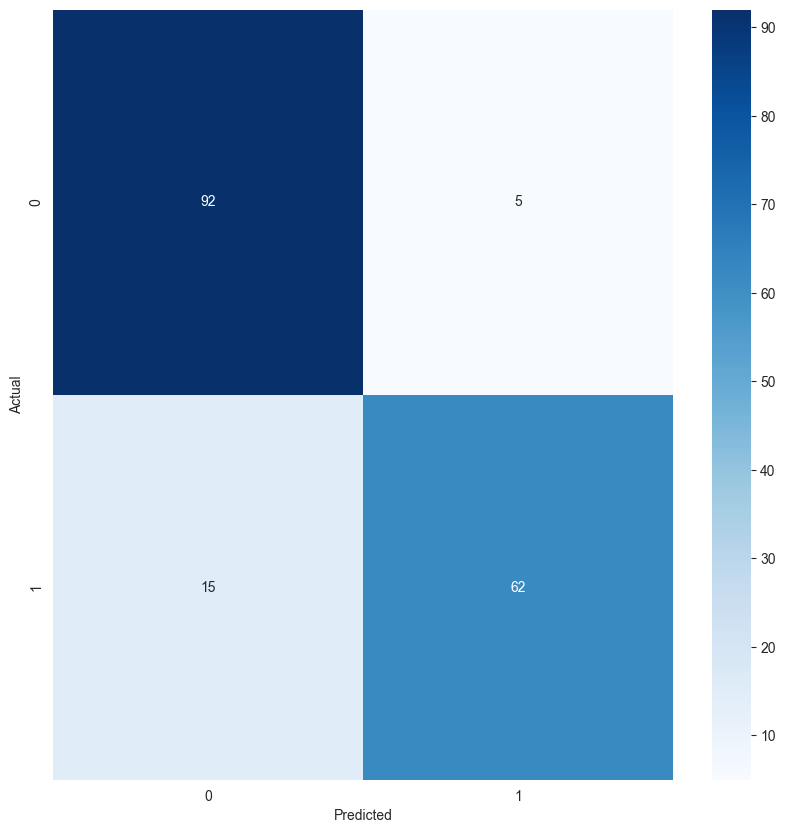

In [57]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()